In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import utils
from sklearn import ensemble
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.optimizers import Adam

In [14]:
# Baze podataka sa 12 stanica u Pekingu bez nedostajucih vrednosti:

filenames =["PRSA_Data_Aotizhongxin_20130301-20170228.csv","PRSA_Data_Changping_20130301-20170228.csv","PRSA_Data_Dingling_20130301-20170228.csv",
            "PRSA_Data_Dongsi_20130301-20170228.csv","PRSA_Data_Guanyuan_20130301-20170228.csv",
            "PRSA_Data_Gucheng_20130301-20170228.csv","PRSA_Data_Huairou_20130301-20170228.csv","PRSA_Data_Nongzhanguan_20130301-20170228.csv",
            "PRSA_Data_Shunyi_20130301-20170228.csv","PRSA_Data_Tiantan_20130301-20170228.csv","PRSA_Data_Wanliu_20130301-20170228.csv","PRSA_Data_Wanshouxigong_20130301-20170228.csv"]
dataframes=[]
for f in filenames:
    dataframes.append(pd.read_csv("data_without_na/"+f,index_col=0))
df_Dingling = dataframes[2].copy()
df_Huairou = dataframes[6].copy()
df_Aotizhongxin = dataframes[0].copy()
df_Changping = dataframes[1].copy()
df_Dongsi = dataframes[3].copy()
df_Guanyuan = dataframes[4].copy()
df_Nongzhanguan =dataframes[7].copy()
df_Shunyi=dataframes[8].copy()
df_Tiantan=dataframes[9].copy()
df_Wanliu=dataframes[10].copy()
df_Wanshouxigong =dataframes[11].copy()
df_Gucheng =dataframes[5].copy()

In [15]:
# Stanice:
stations=[]
for data in dataframes:
    stations.append(data['station'].iloc[0])

In [16]:
# Provera nedostajucih vrednosti:

for data in dataframes:
    print("{}:{}".format(data['station'].iloc[0],np.sum(np.sum(data.isna()))))

Aotizhongxin:0
Changping:0
Dingling:0
Dongsi:0
Guanyuan:0
Gucheng:0
Huairou:0
Nongzhanguan:0
Shunyi:0
Tiantan:0
Wanliu:0
Wanshouxigong:0


In [17]:
# 1. SLUCAJ Primena LSTM-a za predikciju koncentracije PM2.5 u vazduhu naredni sat!
# NE KORISTE SE METEROLOSKI PODACI VEC SAMO KONCENTRACIJE PM2.5 U PRETHODNIM SATIMA!

In [18]:
# Primenicemo na jednu stanicu za ostale je isto!
dataframes[0].head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,heating
2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,0,4.4,Aotizhongxin,0
2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,0,4.7,Aotizhongxin,0
2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,0,5.6,Aotizhongxin,0
2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,0,3.1,Aotizhongxin,0
2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,0,2.0,Aotizhongxin,0


In [19]:
# Napomena: Uzecemo jednu stanicu sa kojom radimo, za ostale je isto!
df=pd.DataFrame(dataframes[0]['PM2.5'])

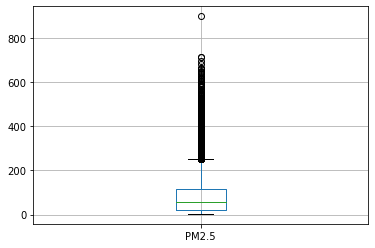

In [20]:
# Box plot:

df.boxplot()
plt.show()

In [21]:
#Standardizacija cele baze jer i y mora biti standardizovano jer cemo raditi lagovane vrednosti!

from sklearn.preprocessing import MinMaxScaler
values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [22]:
with open('models/without_metero.scaler.pickle', 'wb') as model_file:
    pickle.dump(scaler, model_file)

In [23]:
# Siftovanje vrednosti:

def s_to_super(train,window_size):
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [24]:
X, Y = s_to_super(scaled_dataset,4)
X=np.array(X)
Y=np.array(Y)
X.shape,Y.shape

((35060, 4, 1), (35060, 1))

In [25]:
# Podela na trening i test skup i validacioni skup: 

n_train= 24*365 # izaberimo godinu dana za test skup
X_train, X_val, X_test = X[n_train+24*365:,],X[n_train:n_train+24*365,] , X[:n_train,]
Y_train, Y_val, Y_test = Y[n_train+24*365:,],Y[n_train:n_train+24*365,] , Y[:n_train,]

X_train.shape,X_test.shape,X_val.shape,Y_val.shape,Y_train.shape,Y_test.shape

((17540, 4, 1), (8760, 4, 1), (8760, 4, 1), (8760, 1), (17540, 1), (8760, 1))

In [26]:
n_train=X_train.shape[0]
n_test=X_test.shape[0]
n_val=X_val.shape[0]

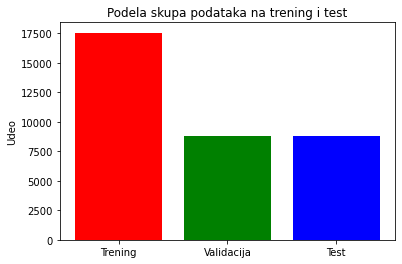

In [28]:

fig, ax = plt.subplots()
bar_trening,bar_val, bar_test = plt.bar([0, 1,2], (n_train,n_val, n_test))

bar_trening.set_facecolor('r')
bar_test.set_facecolor('b')
bar_val.set_facecolor('g')

ax.set_xticks([0, 1,2])
ax.set_xticklabels(['Trening','Validacija', 'Test'])

ax.set_ylabel('Udeo')

ax.set_title('Podela skupa podataka na trening i test');


In [47]:
# Kreiramo LSTM MODEL

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM,Input
model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units = 50, return_sequences = True,activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True,activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mse',metrics=['mae'])

In [48]:
history=model.fit(X_train, Y_train, epochs = 20, batch_size = 32,verbose=1,validation_data=(X_val,Y_val))

Epoch 1/20
549/549 [==============================] - 4s 7ms/step - loss: 0.0025 - mae: 0.0304 - val_loss: 0.0013 - val_mae: 0.0228
Epoch 2/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0014 - mae: 0.0223 - val_loss: 9.2054e-04 - val_mae: 0.0202
Epoch 3/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0011 - mae: 0.0197 - val_loss: 6.2342e-04 - val_mae: 0.0149
Epoch 4/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0010 - mae: 0.0184 - val_loss: 5.7566e-04 - val_mae: 0.0141
Epoch 5/20
549/549 [==============================] - 3s 5ms/step - loss: 9.4188e-04 - mae: 0.0182 - val_loss: 5.8203e-04 - val_mae: 0.0137
Epoch 6/20
549/549 [==============================] - 3s 6ms/step - loss: 8.7884e-04 - mae: 0.0176 - val_loss: 5.7436e-04 - val_mae: 0.0143
Epoch 7/20
549/549 [==============================] - 3s 5ms/step - loss: 8.4462e-04 - mae: 0.0173 - val_loss: 4.9907e-04 - val_mae: 0.0129
Epoch 8/20
549/549 [====================

In [49]:
# Sacuvajmo model
model.save('models/without_metero.h5')

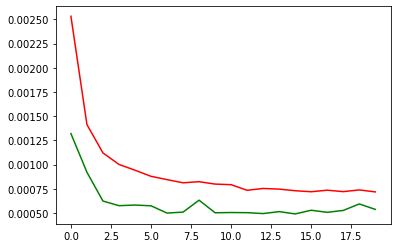

In [50]:
# Pogledajmo sta se desava sa loss funkcijom

plt.plot(history.epoch,history.history['loss'],color='red')
plt.plot(history.epoch,history.history['val_loss'],color='green')
plt.show()

In [52]:
# Predikcije:

Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)

rmse = np.sqrt(mse)
rmse 

# Napomena: 
# Srednje kvadratnu gresku ovog tipa ne mozemo porediti sa srednje kvadratnom greskom na catboost modelu
# zbog standardizacije

0.026259128233079798

In [53]:
X_test.shape,Y_pred.shape

((8760, 4, 1), (8760, 1))

In [54]:
d = scaled_dataset[:8760,:]
Y_predicted = np.concatenate((Y_pred,d[:8760,1:]), axis =1)
Y_tested = np.concatenate((Y_test,d[:8760,1:]), axis = 1)

In [55]:
# Zelimo da vratimo u prethodne vrednosti

Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]

In [56]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse 

# Ova srednjekvadratna greska sada jeste na istoj skali!

23.501919768606424

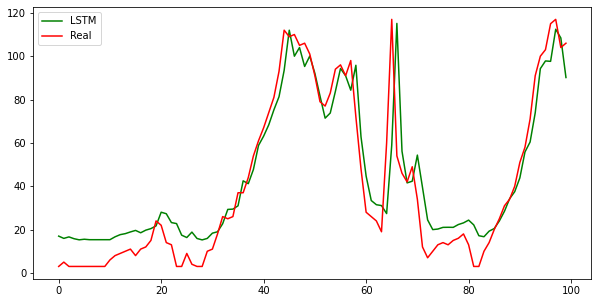

In [57]:
plt.figure(figsize=(10,5))
plt.plot(Y_predicted[:100,:], color= 'green',label='LSTM')
plt.plot(Y_tested[:100,:] , color = 'red',label='Real')
plt.legend()
plt.show()

In [94]:
# 2. SLUCAJ Primena LSTM-a za predikciju koncentracije PM2.5 u vazduhu naredni sat!
# PORED KONCENTRACIJE PM2.5 U PRETHODNIM SATIMA KORISTE SE I METEROLOSKI PODACI

In [95]:
# Primenicemo takodje na jednu stanicu, za ostale je isto!

dataframes[0].head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,heating
2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,0,4.4,Aotizhongxin,0
2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,0,4.7,Aotizhongxin,0
2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,0,5.6,Aotizhongxin,0
2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,0,3.1,Aotizhongxin,0
2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,0,2.0,Aotizhongxin,0


In [96]:
df=pd.DataFrame(dataframes[0][['PM2.5','TEMP','PRES','DEWP','RAIN','wd','WSPM','heating']])

In [97]:
df.head()

,PM2.5,TEMP,PRES,DEWP,RAIN,wd,WSPM,heating
2013-03-01 00:00:00,4.0,-0.7,1023.0,-18.8,0.0,0,4.4,0
2013-03-01 01:00:00,8.0,-1.1,1023.2,-18.2,0.0,0,4.7,0
2013-03-01 02:00:00,7.0,-1.1,1023.5,-18.2,0.0,0,5.6,0
2013-03-01 03:00:00,6.0,-1.4,1024.5,-19.4,0.0,0,3.1,0
2013-03-01 04:00:00,3.0,-2.0,1025.2,-19.5,0.0,0,2.0,0


In [98]:
df.columns

Index(['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'heating'], dtype='object')

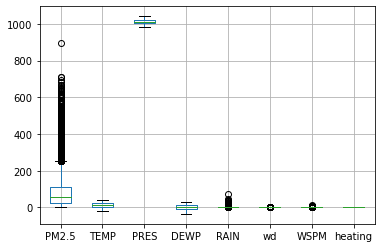

In [99]:
df.boxplot()
plt.show()

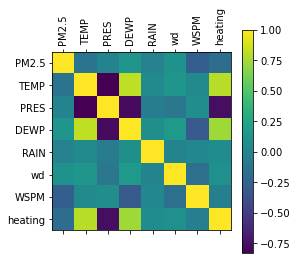

In [100]:
cols =  df.columns
plt.matshow(df.corr())
plt.xticks(range(len(cols)), cols,rotation=90)
plt.yticks(range(len(cols)), cols)
plt.colorbar()
plt.show()

In [101]:
#Standardizacija
from sklearn.preprocessing import MinMaxScaler
values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [102]:
with open('models/with_metero.scaler.pickle', 'wb') as model_file:
    pickle.dump(scaler, model_file)

In [103]:
X, Y =s_to_super(scaled_dataset,4)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (35060, 1)
X (35060, 4, 8)


In [104]:
n_train= 24*365

In [105]:
# Ovde necemo praviti validacioni test
X_train, X_test = X[n_train:,] , X[:n_train,]
Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((26300, 4, 8), (8760, 4, 8), (26300, 1), (8760, 1))

In [106]:
# LSTM model

model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units = 50, return_sequences = True,activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True,activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error',metrics=['mae'])

In [107]:
history=model.fit(X_train, Y_train, epochs = 20, batch_size = 32,verbose=1)

Epoch 1/20
822/822 [==============================] - 4s 5ms/step - loss: 0.0023 - mae: 0.0313
Epoch 2/20
822/822 [==============================] - 4s 4ms/step - loss: 0.0012 - mae: 0.0223
Epoch 3/20
822/822 [==============================] - 4s 4ms/step - loss: 9.9198e-04 - mae: 0.0198
Epoch 4/20
822/822 [==============================] - 3s 4ms/step - loss: 8.8178e-04 - mae: 0.0186
Epoch 5/20
822/822 [==============================] - 3s 4ms/step - loss: 7.8228e-04 - mae: 0.0177
Epoch 6/20
822/822 [==============================] - 4s 4ms/step - loss: 7.5238e-04 - mae: 0.0170
Epoch 7/20
822/822 [==============================] - 4s 5ms/step - loss: 7.1017e-04 - mae: 0.0166
Epoch 8/20
822/822 [==============================] - 3s 4ms/step - loss: 6.7787e-04 - mae: 0.0162
Epoch 9/20
822/822 [==============================] - 3s 4ms/step - loss: 6.8529e-04 - mae: 0.0161
Epoch 10/20
822/822 [==============================] - 4s 4ms/step - loss: 6.6767e-04 - mae: 0.0159
Epoch 11/20
822/8

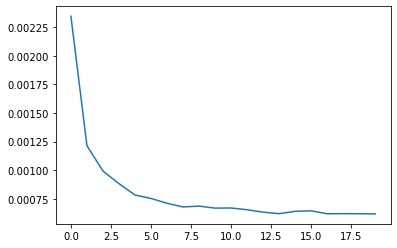

In [108]:
# Pogledajmo loss funkciju

plt.plot(history.epoch,history.history['loss'])
plt.show()

In [126]:
# Sacuvajmo model
model.save('models/with_metero.h5')

In [117]:
Y_pred_with = model.predict(X_test)

mse_with = mean_squared_error(Y_test, Y_pred_with)

rmse_with = np.sqrt(mse_with)
rmse_with

0.02453623512173533

In [118]:
X_test.shape

(8760, 4, 8)

In [119]:
Y_pred_with.shape

(8760, 1)

In [120]:
d = scaled_dataset[:8760,:]
Y_predicted_with = np.concatenate((Y_pred_with,d[:8760,1:]), axis =1)
Y_tested_with = np.concatenate((Y_test, d[:8760,1:]), axis = 1)

In [121]:
Y_predicted_with = scaler.inverse_transform(Y_predicted_with)
Y_tested_with = scaler.inverse_transform(Y_tested_with)
Y_predicted_with = Y_predicted_with[:,0:1]
Y_tested_with = Y_tested_with[:,0:1]

In [122]:
mse_with = mean_squared_error(Y_tested_with, Y_predicted_with)
rmse_with = np.sqrt(mse_with)
rmse_with

21.959930433953122

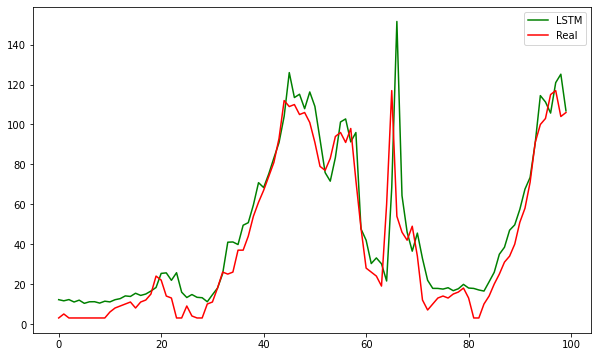

In [123]:
plt.figure(figsize=(10,6))  
plt.plot(Y_predicted_with[:100,:], color= 'green',label = 'LSTM')
plt.plot(Y_tested[:100,:] , color = 'red',label = 'Real')
plt.legend()
plt.show()

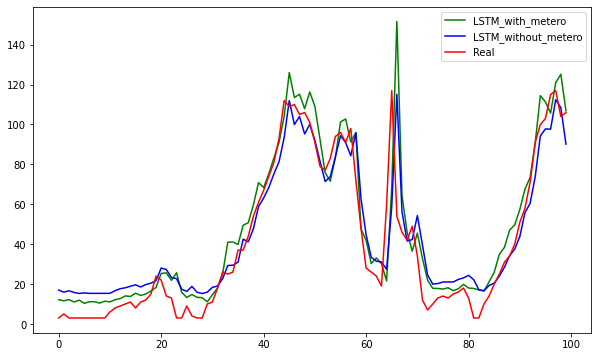

In [124]:
# Poredjenje grafika oba modela
plt.figure(figsize=(10,6))  
plt.plot(Y_predicted_with[:100,:], color= 'green',label = 'LSTM_with_metero')
plt.plot(Y_predicted[:100,:], color= 'blue',label = 'LSTM_without_metero')
plt.plot(Y_tested[:100,:] , color = 'red',label = 'Real')
plt.legend()
plt.show()

In [125]:
# Srednje kvadratne greske sa i bez meteroloskih podataka:
print("Sa meteroloskim podacima: {}".format(rmse_with))
print("Bez meteroloskih podataka: {}".format(rmse))

Sa meteroloskim podacima: 21.959930433953122
Bez meteroloskih podataka: 23.501919768606424
